In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import cv2
from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
%matplotlib inline

C:\Users\zackb\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#define a dictionary with the 4 times of wbc and two potential image types
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

In [3]:
#import training images
eosinophil_train = cv2.imread('dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg')
lymphocyte_train = cv2.imread('dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg')
monocyte_train = cv2.imread('dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_620.jpeg')
neutrophil_train = cv2.imread('dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_0_1986.jpeg')

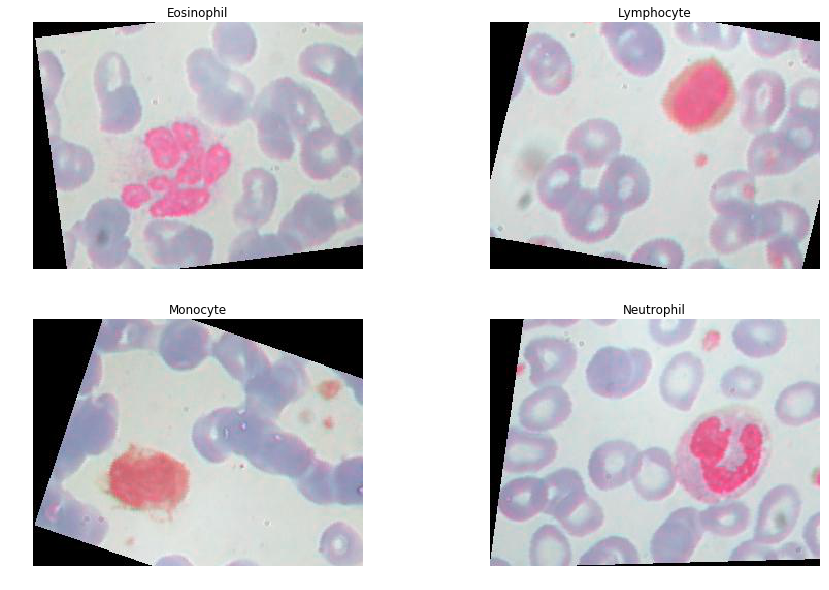

In [4]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.imshow(eosinophil_train)
plt.title('Eosinophil')
plt.axis('off')

plt.subplot(222)
plt.imshow(lymphocyte_train)
plt.title('Lymphocyte')
plt.axis('off')

plt.subplot(223)
plt.imshow(monocyte_train)
plt.title('Monocyte')
plt.axis('off')

plt.subplot(224)
plt.imshow(neutrophil_train)
plt.title('Neutrophil')
plt.axis('off')

plt.show()

In [5]:
#import the label reader and drop the first column, which is empty
labels = pd.read_csv('dataset2-master/dataset2-master/labels.csv')
labels = labels.drop('Unnamed: 0', 1)

In [6]:
print(labels.shape)
print(labels.dtypes)
labels.head()

(411, 2)
Image        int64
Category    object
dtype: object


,Image,Category
0,0,NEUTROPHIL
1,1,NEUTROPHIL
2,2,NEUTROPHIL
3,3,NEUTROPHIL
4,4,NEUTROPHIL


In [7]:
#find a list of records with multiple cells types and drop them and then drop NaN
multiples = labels[labels['Category'].str.contains(',', na=False)].index
df = labels.drop(multiples)
df = df.dropna()

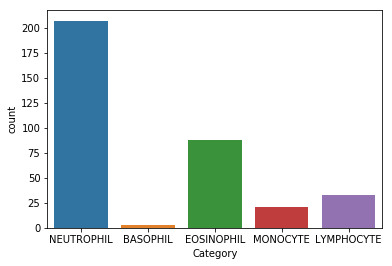

In [8]:
sns.countplot(df['Category'])
plt.show()

In [9]:
from tqdm import tqdm
import os
import skimage

def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = scipy.misc.imresize(arr=img_file, size=(60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
X_train, y_train, z_train = get_data('dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('dataset2-master/dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
print(dict_characters)
print(dict_characters2)

  0%|                                                                                         | 0/2497 [00:00<?, ?it/s]C:\Users\zackb\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:01<00:00, 575.46it/s]


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}
